# Set Up

In [0]:
import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt
from keras import models
from keras import optimizers
from keras import layers

Using TensorFlow backend.


In [0]:
def sim_square(img_dim, sq_radius):
  '''
  Generate a greyscale image of shape (img_dim, img_dim, 1) with a square of radius
  sq_radius in it.

  Arguments:
   - img_dim: dimension of image in pixels
   - sq_radius: radius of square.  square is of width 2*radius
  '''
  result = np.full((img_dim, img_dim, 1), 255)
  center = np.random.randint(
      low = sq_radius,
      high = img_dim - sq_radius + 1,
      size = (2,)
  )
  result[(center[0] - sq_radius):(center[0] + sq_radius),
         (center[1] - sq_radius):(center[1] + sq_radius), 0] = 0
  return(result)

def sim_triangle(img_dim, tri_radius):
  '''
  Generate a greyscale image of shape (img_dim, img_dim) with a triangle of
  radius tri_radius in it.

  Arguments:
   - img_dim: dimension of image in pixels
   - tri_radius: radius of triangle.  bottom of triangle is of width 2*radius
  '''
  result = np.full((img_dim, img_dim, 1), 255)
  center = np.random.randint(
      low = tri_radius,
      high = img_dim - tri_radius,
      size = (2,)
  )
  
  for i in range(2*tri_radius):
    result[center[0] + tri_radius - i, (center[1] - tri_radius):(center[1] - tri_radius + i + 1), 0] = 0
  return(result)

def sim_data(n, img_dim, radius):
  x = np.ndarray((2*n, img_dim, img_dim, 1))
  for i in range(n):
    x[i, ...] = sim_square(img_dim, radius)

  for i in range(n):
    x[n + i, ...] = sim_triangle(img_dim, radius)
  
  y = np.concatenate((np.ones((n, 1)), np.zeros((n, 1))), axis = 0)

  return(x, y)

def do_convolutions(A, Ws):
  '''
  Do convolution of input A with filters W

  Arguments:
   - A: input of shape (n_H, n_W, n_C)
   - Ws: list of filters, each of shape (f, f, n_C)
  
  Return:
   - filtered result
  '''
  (n_H, n_W, n_C) = A.shape
  n_C_out = len(Ws)
  f = Ws[0].shape[0]

  output = np.zeros((n_H - f + 1, n_W - f + 1, n_C_out))
  for i in range(n_H - f + 1):
    for j in range(n_W - f + 1):
      for c in range(n_C_out):
        output[i, j, c] = np.sum(A[i:(i+f), j:(j+f), :] * Ws[c])
  
  return(output)

def max_pool(A, s):
  (n_H, n_W, n_C) = A.shape
  n_H_out = int(n_H/s)
  n_W_out = int(n_W/s)

  output = np.zeros((n_H_out, n_W_out, n_C))
  for i in range(n_H_out):
    for j in range(n_W_out):
      start_row = i*s
      end_row = (i+1)*s
      start_col = j*s
      end_col = (j+1)*s
      for c in range(n_C):
        output[i, j, c] = np.max(A[start_row:end_row, start_col:end_col, c])
  
  return(output)


def dense_layer(A, W):
  return(relu(np.sum(np.squeeze(A) * W)))


def relu(z):
  '''
  ReLU function

  Arguments:
   - z: numpy array of real numbers
  
  Return:
   - elementwise maximum of z and 0
  '''

  return(np.maximum(0, z))

# Square and Triangle

(24, 24, 1)


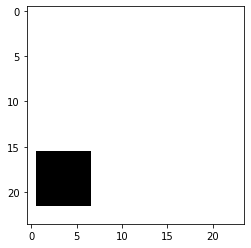

In [0]:
np.random.seed(4381)
sq = sim_square(24, 3)
print(sq.shape)
plt.imshow(sq[:,:,0], cmap = "gray")

In [0]:
sq[:,:,0]

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255

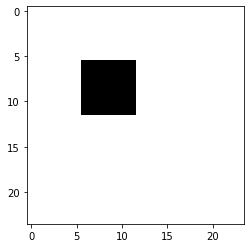

In [0]:
sq = sim_square(24, 3)
plt.imshow(sq[:,:,0], cmap = "gray")

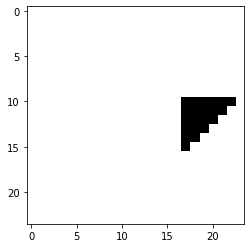

In [0]:
tri = sim_triangle(24, 3)
plt.imshow(tri[:,:,0], cmap = "gray")

# Manual Neural Network

## First Hidden Layer: Convolutional, Edge Detection

I manually specify five different 5 by 5 filters:

In [0]:
W_vert_left = np.array([[1, 1, 0, -1, -1],
                        [1, 1, 0, -1, -1],
                        [1, 1, 0, -1, -1],
                        [1, 1, 0, -1, -1],
                        [1, 1, 0, -1, -1]]).reshape((5,5,1))
b_vert_left = -2100

W_vert_right = np.array([[-1, -1, 0, 1, 1],
                        [-1, -1, 0, 1, 1],
                        [-1, -1, 0, 1, 1],
                        [-1, -1, 0, 1, 1],
                        [-1, -1, 0, 1, 1]]).reshape((5,5,1))
b_vert_right = -2100

W_horiz_top = np.array([[1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1],
                        [0, 0, 0, 0, 0],
                        [-1, -1, -1, -1, -1],
                        [-1, -1, -1, -1, -1]]).reshape((5,5,1))
b_horiz_top = -2100

W_horiz_bottom = np.array([[-1, -1, -1, -1, -1],
                           [-1, -1, -1, -1, -1],
                         [0, 0, 0, 0, 0],
                         [1, 1, 1, 1, 1],
                         [1, 1, 1, 1, 1]]).reshape((5,5,1))
b_horiz_bottom = -2100

W_45_lower_right = np.array([[-1, -1, -1, -1, 0],
                     [-1, -1, -1, 0, 1],
                     [-1, -1, 0, 1, 1],
                     [-1, 0, 1, 1, 1],
                     [0, 1, 1, 1, 1]]).reshape((5,5,1))
b_45_lower_right = -2100

all_W1 = [W_vert_left, W_vert_right, W_horiz_top, W_horiz_bottom, W_45_lower_right]
all_b1 = np.array([b_vert_left, b_vert_right, b_horiz_top, b_horiz_bottom, b_45_lower_right]).reshape(1, 1, 5)

Calculating the activation outputs for the square and for the triangle:

In [0]:
sq_z_no_b1 = do_convolutions(sq, all_W1)
sq_z1 = sq_z_no_b1 + all_b1
sq_a1 = relu(sq_z1)
print("shape = " + str(sq_a1.shape))

tri_z_no_b1 = do_convolutions(tri, all_W1)
tri_z1 = tri_z_no_b1 + all_b1
tri_a1 = relu(tri_z1)
print("shape = " + str(tri_a1.shape))

shape = (20, 20, 5)
shape = (20, 20, 5)


Here's a display of the filter outputs for the square image:


filter 0
largest z value before adding b = 2550.0
largest a value = 450.0

filter 1
largest z value before adding b = 2550.0
largest a value = 450.0

filter 2
largest z value before adding b = 2550.0
largest a value = 450.0

filter 3
largest z value before adding b = 2550.0
largest a value = 450.0

filter 4
largest z value before adding b = 2040.0
largest a value = 0.0


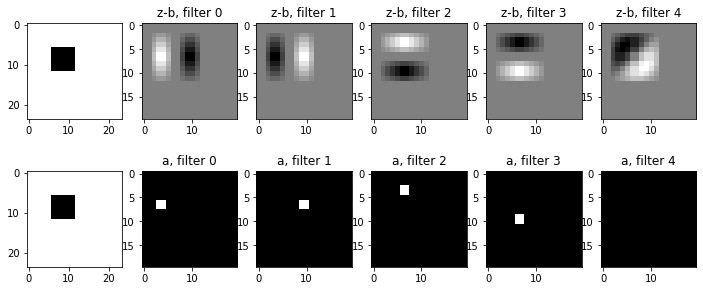

In [0]:
fig, axs = plt.subplots(2, 6, figsize=(12, 5))
axs[0,0].imshow(sq[:, :, 0], cmap = "gray")
axs[1,0].imshow(sq[:, :, 0], cmap = "gray")

b = -2100.0

for i in range(5):
  print("\nfilter " + str(i))
  print("largest z value before adding b = " + str(np.max(sq_z_no_b1[:,:,i])))
  print("largest a value = " + str(np.max(sq_a1[:,:,i])))

  axs[0, i+1].imshow(sq_z_no_b1[:,:,i], cmap = "gray")
  axs[0, i+1].set_title("z-b, filter " + str(i))
  axs[1, i+1].imshow(sq_a1[:,:,i], cmap = "gray")
  axs[1, i+1].set_title("a, filter " + str(i))

Here's a display of the filter outputs for the triangle image:


filter 0
largest z value before adding b = 2550.0
largest a value = 450.0

filter 1
largest z value before adding b = 1530.0
largest a value = 0.0

filter 2
largest z value before adding b = 2550.0
largest a value = 450.0

filter 3
largest z value before adding b = 1530.0
largest a value = 0.0

filter 4
largest z value before adding b = 2550.0
largest a value = 450.0


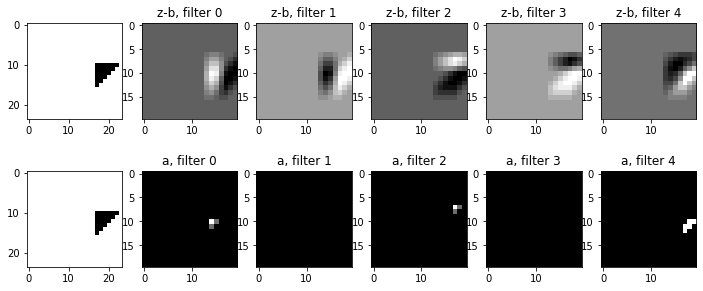

In [0]:
fig, axs = plt.subplots(2, 6, figsize=(12, 5))
axs[0,0].imshow(tri[:, :, 0], cmap = "gray")
axs[1,0].imshow(tri[:, :, 0], cmap = "gray")

b = -2100.0

for i in range(5):
  print("\nfilter " + str(i))
  print("largest z value before adding b = " + str(np.max(tri_z_no_b1[:,:,i])))
  print("largest a value = " + str(np.max(tri_a1[:,:,i])))

  axs[0, i+1].imshow(tri_z_no_b1[:,:,i], cmap = "gray")
  axs[0, i+1].set_title("z-b, filter " + str(i))
  axs[1, i+1].imshow(tri_a1[:,:,i], cmap = "gray")
  axs[1, i+1].set_title("a, filter " + str(i))

In [0]:
np.where(sq_a1[:,:,0] > 0)

(array([6, 6, 7, 7]), array([3, 4, 3, 4]))

In [0]:
np.where(sq_a1[:,:,1] > 0)

(array([6, 6, 7, 7]), array([ 9, 10,  9, 10]))

In [0]:
np.where(sq_a1[:,:,2] > 0)

(array([3, 3, 4, 4]), array([6, 7, 6, 7]))

In [0]:
np.where(sq_a1[:,:,3] > 0)

(array([ 9,  9, 10, 10]), array([6, 7, 6, 7]))

In [0]:
sq_a1.shape

(20, 20, 5)

## Second Hidden Layer: Max Pooling, Size Reduction

In [0]:
sq_a2 = max_pool(sq_a1, 2)
tri_a2 = max_pool(tri_a1, 2)
print(sq_a2.shape)
print(np.where(sq_a2[:,:,0] > 0))
print(np.where(sq_a2[:,:,1] > 0))
print(np.where(sq_a2[:,:,2] > 0))
print(np.where(sq_a2[:,:,3] > 0))

(10, 10, 5)
(array([3, 3]), array([1, 2]))
(array([3, 3]), array([4, 5]))
(array([1, 2]), array([3, 3]))
(array([4, 5]), array([3, 3]))


## Third Hidden Layer: Convolutional, Corner Detection

In [0]:
# Filter to detect a top left square (or triangle) corner
W_90_corner_top_left = np.zeros((3, 3, 5)) # mostly irrelevant

# vertical left edge (channel 0 of previous layer) exists
# in lower-left corner of this 3 by 3 patch of previous layer's activations
W_90_corner_top_left[[1,1,2,2], [0,1,0,1], 0] = 1.0

# horizontal top edge (channel 2 of previous layer) exists
# in upper-right corner of this 3 by 3 patch of previous layer's activations
W_90_corner_top_left[[0,0,1,1], [1,2,1,2], 2] = 1.0

b_90_corner_top_left = -1000


# Filter to detect a top right square corner
W_90_corner_top_right = np.zeros((3, 3, 5)) # mostly irrelevant

# vertical right edge (channel 1 of previous layer) exists
# in lower-right corner of this 3 by 3 patch of previous layer's activations
W_90_corner_top_right[[1,1,2,2], [1,2,1,2], 1] = 1.0

# horizontal top edge (channel 2 of previous layer) exists
# in upper-left corner of this 3 by 3 patch of previous layer's activations
W_90_corner_top_right[[0,0,1,1], [0,1,0,1], 2] = 1.0

b_90_corner_top_right = -1000


# Filter to detect a bottom left square corner
W_90_corner_bottom_left = np.zeros((3, 3, 5)) # mostly irrelevant

# vertical left edge (channel 0 of previous layer) exists
# in upper-left corner of this 3 by 3 patch of previous layer's activations
W_90_corner_bottom_left[[0,0,1,1], [0,1,0,1], 0] = 1.0

# horizontal bottom edge (channel 3 of previous layer) exists
# in lower-right corner of this 3 by 3 patch of previous layer's activations
W_90_corner_bottom_left[[1,1,2,2], [1,2,1,2], 3] = 1.0

b_90_corner_bottom_left = -1000


# Filter to detect a bottom right square corner
W_90_corner_bottom_right = np.zeros((3, 3, 5)) # mostly irrelevant

# vertical right edge (channel 1 of previous layer) exists
# in upper-right corner of this 3 by 3 patch of previous layer's activations
W_90_corner_bottom_right[[0,0,1,1], [1,2,1,2], 1] = 1.0

# horizontal bottom edge (channel 3 of previous layer) exists
# in lower-left corner of this 3 by 3 patch of previous layer's activations
W_90_corner_bottom_right[[1,1,2,2], [0,1,0,1], 3] = 1.0

b_90_corner_bottom_right = -1000


# Filter to detect a top right triangle corner
W_45_corner_top_right = np.zeros((3, 3, 5)) # mostly irrelevant

# vertical left edge (channel 0 of previous layer) exists
# in lower-left corner of this 3 by 3 patch of previous layer's activations
W_45_corner_top_right[[1,1,2,2], [0,1,0,1], 0] = 1.0

# diagonal edge (channel 4 of previous layer) exists
# in middle-to-lower part of this 3 by 3 patch of previous layer's activations
W_45_corner_top_right[[1,1,1,2,2,2], [0,1,2,0,1,2], 4] = 1.0

b_45_corner_top_right = -1000


# Filter to detect a bottom left triangle corner
W_45_corner_bottom_left = np.zeros((3, 3, 5)) # mostly irrelevant

# vertical left edge (channel 0 of previous layer) exists
# in upper-left corner of this 3 by 3 patch of previous layer's activations
W_45_corner_bottom_left[[0,0,1,1], [0,1,0,1], 0] = 1.0

# diagonal edge (channel 4 of previous layer) exists
# in middle-to-right side of this 3 by 3 patch of previous layer's activations
W_45_corner_bottom_left[[0,0,1,1,2,2], [1,2,1,2,1,2], 4] = 1.0

b_45_corner_bottom_left = -1000


all_W3 = [W_90_corner_top_left, W_90_corner_top_right,
          W_90_corner_bottom_left, W_90_corner_bottom_right,
          W_45_corner_top_right, W_45_corner_bottom_left]
all_b3 = np.array([b_90_corner_top_left, b_90_corner_top_right,
          b_90_corner_bottom_left, b_90_corner_bottom_right,
          b_45_corner_top_right, b_45_corner_bottom_left]).reshape(1, 1, 6)

Calculating the activation outputs:

In [0]:
sq_z_no_b3 = do_convolutions(sq_a2, all_W3)
sq_z3 = sq_z_no_b3 + all_b3
sq_a3 = relu(sq_z3)
print("shape = " + str(sq_a3.shape))

tri_z_no_b3 = do_convolutions(tri_a2, all_W3)
tri_z3 = tri_z_no_b3 + all_b3
tri_a3 = relu(tri_z3)
print("shape = " + str(tri_a3.shape))

shape = (8, 8, 6)
shape = (8, 8, 6)


Here's a display of the filter outputs for the square image:


filter 0
largest z value before adding b = 1800.0
largest a value = 800.0

filter 1
largest z value before adding b = 1800.0
largest a value = 800.0

filter 2
largest z value before adding b = 1800.0
largest a value = 800.0

filter 3
largest z value before adding b = 1800.0
largest a value = 800.0

filter 4
largest z value before adding b = 900.0
largest a value = 0.0

filter 5
largest z value before adding b = 900.0
largest a value = 0.0


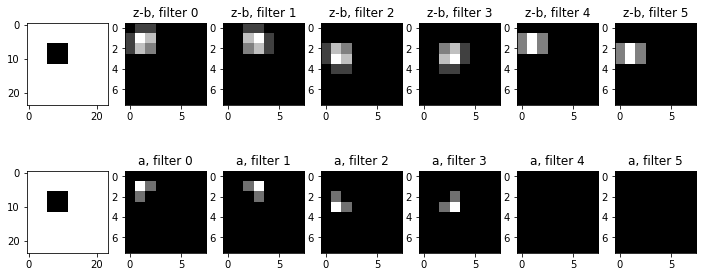

In [0]:
fig, axs = plt.subplots(2, 7, figsize=(12, 5))
axs[0,0].imshow(sq[:, :, 0], cmap = "gray")
axs[1,0].imshow(sq[:, :, 0], cmap = "gray")

for i in range(6):
  print("\nfilter " + str(i))
  print("largest z value before adding b = " + str(np.max(sq_z_no_b3[:,:,i])))
  print("largest a value = " + str(np.max(sq_a3[:,:,i])))

  axs[0, i+1].imshow(sq_z_no_b3[:,:,i], cmap = "gray")
  axs[0, i+1].set_title("z-b, filter " + str(i))
  axs[1, i+1].imshow(sq_a3[:,:,i], cmap = "gray")
  axs[1, i+1].set_title("a, filter " + str(i))


filter 0
largest z value before adding b = 1290.0
largest a value = 290.0

filter 1
largest z value before adding b = 645.0
largest a value = 0.0

filter 2
largest z value before adding b = 450.0
largest a value = 0.0

filter 3
largest z value before adding b = 0.0
largest a value = 0.0

filter 4
largest z value before adding b = 1800.0
largest a value = 800.0

filter 5
largest z value before adding b = 1800.0
largest a value = 800.0


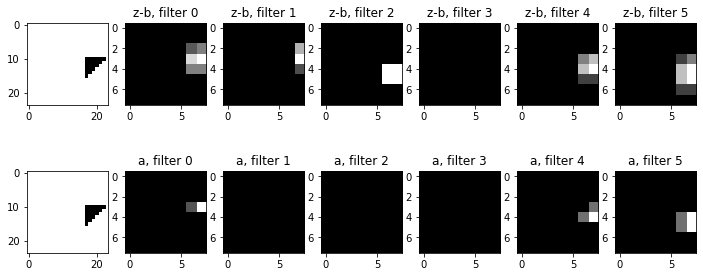

In [0]:
fig, axs = plt.subplots(2, 7, figsize=(12, 5))
axs[0,0].imshow(tri[:, :, 0], cmap = "gray")
axs[1,0].imshow(tri[:, :, 0], cmap = "gray")

for i in range(6):
  print("\nfilter " + str(i))
  print("largest z value before adding b = " + str(np.max(tri_z_no_b3[:,:,i])))
  print("largest a value = " + str(np.max(tri_a3[:,:,i])))

  axs[0, i+1].imshow(tri_z_no_b3[:,:,i], cmap = "gray")
  axs[0, i+1].set_title("z-b, filter " + str(i))
  axs[1, i+1].imshow(tri_a3[:,:,i], cmap = "gray")
  axs[1, i+1].set_title("a, filter " + str(i))

## Output Layer: Fully Connected, Probability of Square

In [0]:
W4 = np.concatenate(
    (np.zeros((8,8,1)), # detection of upper left square corner irrelevant
    np.ones((8,8,1)), # detection of upper right square corner indicates square
    np.ones((8,8,1)), # detection of lower left square corner indicates square
    np.ones((8,8,1)), # detection of lower right square corner indicates square
    -1*np.ones((8,8,1)), # detection of upper left triangle corner indicates not square
    -1*np.ones((8,8,1))), # detection of lower left triangle corner indicates not square
    axis = 2
).reshape(-1, 1)
b4 = 0

print(W4.shape)

(384, 1)


In [0]:
sq_a3_vec = sq_a3.reshape(-1, 1)
print(sq_a3_vec.shape)
sq_a4 = sigmoid(b4 + np.dot(W4.T, sq_a3_vec))
print(sq_a4)

(384, 1)
[[1.]]


In [0]:
tri_a3_vec = tri_a3.reshape(-1, 1)
tri_a4 = sigmoid(b4 + np.dot(W4.T, tri_a3_vec))
print(tri_a4)

[[0.]]


## Function to predict from this model

In [0]:
def predict_my_nn(X):
  # layer 1
  z1 = do_convolutions(X, all_W1) + all_b1
  a1 = relu(z1)

  # layer2
  a2 = max_pool(a1, 2)

  # layer 3
  z3 = do_convolutions(a2, all_W3) + all_b3
  a3 = relu(z3)

  # layer 4
  a3_vec = a3.reshape(-1, 1)
  a4 = sigmoid(b4 + np.dot(W4.T, a3_vec))

  return(a4)

# Model in Keras
## Generate a bunch of images

Let's make a training data set with 50 images of squares and 50 images of triangles.

In [0]:
np.random.seed(5434)
(train_x, train_y) = sim_data(n = 50, img_dim = 24, radius = 3)
(val_x, val_y) = sim_data(n = 50, img_dim = 24, radius = 3)
print(train_x.shape)
print(train_y.shape)

(100, 24, 24, 1)
(100, 1)


For estimation to work, we need to standardize the data.  For image data, the most common way to do this is to just divide everything by 255 to values between 0 and 1.

In [0]:
train_x_scaled = train_x.astype(float) / 255
val_x_scaled = val_x.astype(float) / 255

### First Keras Model
Exactly the same structure as our hand-made model above.

In [0]:
model1 = models.Sequential()
model1.add(layers.Conv2D(5, (5, 5), activation = 'relu', input_shape = (24, 24, 1)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(6, (3, 3), activation = 'relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(1, activation = 'sigmoid'))

model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model1.fit(train_x_scaled, train_y, epochs = 250, batch_size = 100, validation_data = (val_x_scaled, val_y))

Train on 100 samples, validate on 100 samples
Epoch 1/250
100/100 [==============================] - 0s 5ms/step - loss: 0.6937 - acc: 0.4800 - val_loss: 0.6880 - val_acc: 0.5200
Epoch 2/250
100/100 [==============================] - 0s 510us/step - loss: 0.6925 - acc: 0.5100 - val_loss: 0.6876 - val_acc: 0.5700
Epoch 3/250
100/100 [==============================] - 0s 407us/step - loss: 0.6914 - acc: 0.5400 - val_loss: 0.6873 - val_acc: 0.6000
Epoch 4/250
100/100 [==============================] - 0s 384us/step - loss: 0.6903 - acc: 0.5700 - val_loss: 0.6869 - val_acc: 0.6200
Epoch 5/250
100/100 [==============================] - 0s 400us/step - loss: 0.6893 - acc: 0.6000 - val_loss: 0.6865 - val_acc: 0.6000
Epoch 6/250
100/100 [==============================] - 0s 439us/step - loss: 0.6881 - acc: 0.6100 - val_loss: 0.6861 - val_acc: 0.6000
Epoch 7/250
100/100 [==============================] - 0s 417us/step - loss: 0.6869 - acc: 0.6000 - val_loss: 0.6857 - val_acc: 0.6000
Epoch 8/250

In [0]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 20, 20, 5)         130       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 5)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 6)           276       
_________________________________________________________________
flatten_3 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 385       
Total params: 791
Trainable params: 791
Non-trainable params: 0
_________________________________________________________________


## Validation set accuracy for our hand-made model

In [0]:
yhat = np.ndarray((100,1))
for i in range(100):
  yhat[i,0] = predict_my_nn(val_x[i, ...]).astype(int)

np.mean(yhat == val_y)

1.0

## Visualizing Keras Model Activations

We can plot the activation outputs from each unit (or a selection of units) in a Keras model using the following code (adapted from Chapter 5 of Chollet).  This is what we did with our regression models last week, and with our hand-made model above.


In [0]:
# extract a list with the outputs from all layers in the model
layer_outputs = [layer.output for layer in model1.layers]
print(layer_outputs)

# create a new model with all these layers as outputs
# instead of 1 output layer at the end, we get to see the outputs from every layer
activation_model = models.Model(inputs = model1.input, outputs = layer_outputs)

[<tf.Tensor 'conv2d_5/Relu:0' shape=(?, 20, 20, 5) dtype=float32>, <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(?, 10, 10, 5) dtype=float32>, <tf.Tensor 'conv2d_6/Relu:0' shape=(?, 8, 8, 6) dtype=float32>, <tf.Tensor 'flatten_3/Reshape:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'dense_3/Sigmoid:0' shape=(?, 1) dtype=float32>]


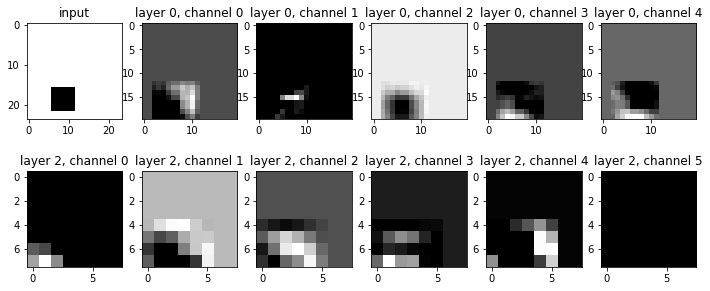

In [0]:
# call predict to get the activations for a square and a triangle
input_img = val_x[0:1,...]
activations = activation_model.predict(input_img)
#tri_activations = activation_model.predict(val_x[1:2,...])

fig, axs = plt.subplots(2, 6, figsize=(12, 5))
axs[0,0].imshow(input_img[0, :, :, 0], cmap = "gray")
axs[0,0].set_title("input")

# layer 0 activations
for i in range(5):
  axs[0, i+1].imshow(activations[0][0,:,:,i], cmap = "gray")
  axs[0, i+1].set_title("layer 0, channel " + str(i))

# layer 2 activations
for i in range(6):
  axs[1, i].imshow(activations[2][0,:,:,i], cmap = "gray")
  axs[1, i].set_title("layer 2, channel " + str(i))


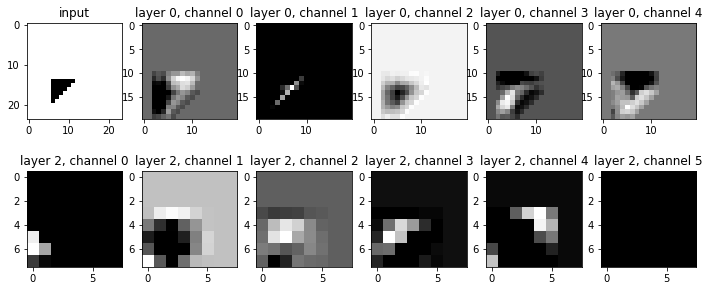

In [0]:
# call predict to get the activations for a square and a triangle
input_img = val_x[50:51,...]
activations = activation_model.predict(input_img)
#tri_activations = activation_model.predict(val_x[1:2,...])

fig, axs = plt.subplots(2, 6, figsize=(12, 5))
axs[0,0].imshow(input_img[0, :, :, 0], cmap = "gray")
axs[0,0].set_title("input")

# layer 0 activations
for i in range(5):
  axs[0, i+1].imshow(activations[0][0,:,:,i], cmap = "gray")
  axs[0, i+1].set_title("layer 0, channel " + str(i))

# layer 2 activations
for i in range(6):
  axs[1, i].imshow(activations[2][0,:,:,i], cmap = "gray")
  axs[1, i].set_title("layer 2, channel " + str(i))
